In [3]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

DATA_DIR = Path("../../data_csv")  # 네 repo 구조 기준 (core 폴더에서 실행)
NASA_PATH = DATA_DIR / "NASA_Battery_Degradation.csv"

print("NASA_PATH exists:", NASA_PATH.exists())
NASA_PATH

nasa_df = pd.read_csv(NASA_PATH)

print("shape:", nasa_df.shape)
print("columns:", nasa_df.columns.tolist())
nasa_df.head()

print(nasa_df.dtypes)
print("\nNA count (top):")
display(nasa_df.isna().sum().sort_values(ascending=False).head(10))

NASA_PATH exists: True
shape: (1415, 7)
columns: ['battery_id', 'cycle', 'voltage', 'temperature', 'capacity', 'soh', 'rul']
battery_id      object
cycle            int64
voltage        float64
temperature    float64
capacity       float64
soh            float64
rul              int64
dtype: object

NA count (top):


battery_id     0
cycle          0
voltage        0
temperature    0
capacity       0
soh            0
rul            0
dtype: int64

목적: prediction(노이즈) vs state(완만/단조) 를 시간축으로 비교
 - "상태": soh (이미 컬럼 존재)
 - "예측값(대체)": capacity 를 '노이즈가 섞인 관측/추정치'로 간주
   (여기서 모델 만들지 않음. cutoff 없음.)

In [4]:
REQUIRED_COLS = ["battery_id", "cycle", "capacity", "soh"]

missing = [c for c in REQUIRED_COLS if c not in nasa_df.columns]
print("missing:", missing)

core = nasa_df[REQUIRED_COLS].copy()
core.head()

# 배터리 1개 선택 (재현 가능한 방식)
# - 가장 cycle 수가 많은 battery_id를 고정 선택

battery_counts = core.groupby("battery_id")["cycle"].nunique().sort_values(ascending=False)
display(battery_counts.head(10))

TARGET_BATTERY_ID = battery_counts.index[0]
print("TARGET_BATTERY_ID:", TARGET_BATTERY_ID)

one = core[core["battery_id"] == TARGET_BATTERY_ID].copy()
one = one.sort_values("cycle").reset_index(drop=True)

print("one shape:", one.shape)
one.head()

# "예측값" vs "상태" 정의
# - 상태(state): soh (원본 그대로)
# - 예측(pred proxy): capacity에 노이즈를 의도적으로 섞은 'noisy_pred_capacity'
#   (모델 성능 얘기 금지. 그냥 "예측/추정치에는 노이즈가 있다"를 재현)

rng = np.random.default_rng(42)

one["state_soh"] = one["soh"].astype(float)
one["pred_capacity_raw"] = one["capacity"].astype(float)

# 노이즈 스케일: capacity 표준편차의 일부
noise_scale = one["pred_capacity_raw"].std(ddof=0) * 0.15
one["pred_capacity_noisy"] = one["pred_capacity_raw"] + rng.normal(0, noise_scale, size=len(one))

# 비교를 더 명확히 하려면 smoothing 하나만 추가 (단순 rolling 평균만)
ROLL_W = 10
one["pred_capacity_noisy_rollmean"] = one["pred_capacity_noisy"].rolling(ROLL_W, min_periods=1).mean()

one[["cycle", "pred_capacity_raw", "pred_capacity_noisy", "pred_capacity_noisy_rollmean", "state_soh"]].head(15)

missing: []


battery_id
B0005    168
B0007    168
B0006    155
B0018    132
B0042     99
B0045     70
B0048     69
B0046     69
B0047     69
B0043     66
Name: cycle, dtype: int64

TARGET_BATTERY_ID: B0005
one shape: (168, 4)


,cycle,pred_capacity_raw,pred_capacity_noisy,pred_capacity_noisy_rollmean,state_soh
0,1,1.861976,1.870696,1.870696,1.000000
1,2,1.851862,1.822102,1.846399,0.994568
2,3,1.840808,1.862282,1.851694,0.988631
3,4,1.850058,1.876973,1.858013,0.993599
4,5,1.849432,1.793603,1.845131,0.993263
5,6,1.841138,1.803875,1.838255,0.988808
6,7,1.840621,1.844280,1.839116,0.988531
7,8,1.831164,1.822114,1.836991,0.983452
8,9,1.839546,1.839065,1.837221,0.987953
9,10,1.830019,1.805609,1.834060,0.982837


시간축 비교 플롯 1: pred(노이즈) vs state(완만)

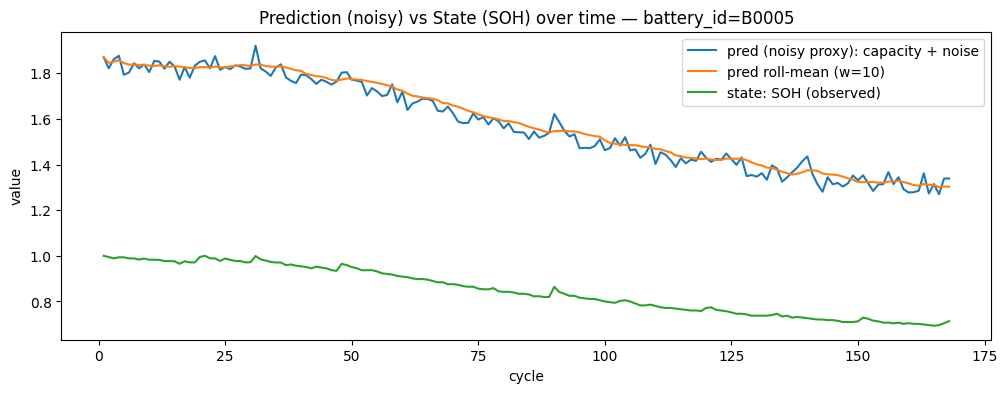

In [5]:
plt.figure(figsize=(12, 4))
plt.plot(one["cycle"], one["pred_capacity_noisy"], label="pred (noisy proxy): capacity + noise")
plt.plot(one["cycle"], one["pred_capacity_noisy_rollmean"], label=f"pred roll-mean (w={ROLL_W})")
plt.plot(one["cycle"], one["state_soh"], label="state: SOH (observed)")
plt.title(f"Prediction (noisy) vs State (SOH) over time — battery_id={TARGET_BATTERY_ID}")
plt.xlabel("cycle")
plt.ylabel("value")
plt.legend()
plt.show()

“예측은 흔들려도 상태는 완충층처럼 움직인다”를 숫자로도 확인
 (성능지표 아님 / cutoff 없음)
 - pred 변화량(절대값) vs state 변화량(절대값)의 크기 비교

In [6]:
one["pred_delta_abs"] = one["pred_capacity_noisy"].diff().abs()
one["state_delta_abs"] = one["state_soh"].diff().abs()

summary = {
    "battery_id": TARGET_BATTERY_ID,
    "n_steps": int(one["cycle"].nunique()),
    "mean_abs_pred_delta": float(one["pred_delta_abs"].mean(skipna=True)),
    "mean_abs_state_delta": float(one["state_delta_abs"].mean(skipna=True)),
    "median_abs_pred_delta": float(one["pred_delta_abs"].median(skipna=True)),
    "median_abs_state_delta": float(one["state_delta_abs"].median(skipna=True)),
}
summary

{'battery_id': 'B0005',
 'n_steps': 168,
 'mean_abs_pred_delta': 0.02929838564983214,
 'mean_abs_state_delta': 0.0049946859522136304,
 'median_abs_pred_delta': 0.026562847166418102,
 'median_abs_state_delta': 0.0030887399413708216}

예측 변화 vs 상태 변화 산점도 (노이즈 대비)
 - 예측 변화가 커도, 상태 변화는 작거나 완만한 영역이 많으면 "완충층" 관찰 강화


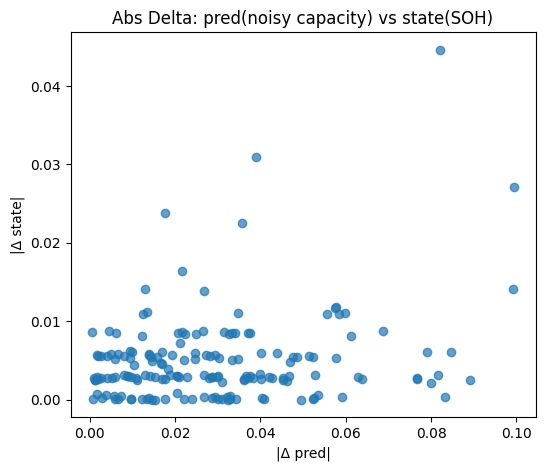

In [7]:
tmp = one.dropna(subset=["pred_delta_abs", "state_delta_abs"]).copy()

plt.figure(figsize=(6, 5))
plt.scatter(tmp["pred_delta_abs"], tmp["state_delta_abs"], alpha=0.7)
plt.title("Abs Delta: pred(noisy capacity) vs state(SOH)")
plt.xlabel("|Δ pred|")
plt.ylabel("|Δ state|")
plt.show()

In [8]:
print(f"""
[Core4-02 관찰 고정]

- Battery(battery_id={TARGET_BATTERY_ID})에서 '예측/추정치' 역할로 둔 capacity(noisy)는 cycle별로 흔들린다.
- 그러나 상태(state)로 둔 SOH는 시간축에서 상대적으로 완만하게 변한다.
- 즉, 예측의 단기 노이즈가 곧바로 개입 트리거가 되지 않게 만드는 '상태 완충층'이 존재하는 구조로 관찰된다.

(항체 데이터는 이 노트북에서 불러오지 않음)
""")


[Core4-02 관찰 고정]

- Battery(battery_id=B0005)에서 '예측/추정치' 역할로 둔 capacity(noisy)는 cycle별로 흔들린다.
- 그러나 상태(state)로 둔 SOH는 시간축에서 상대적으로 완만하게 변한다.
- 즉, 예측의 단기 노이즈가 곧바로 개입 트리거가 되지 않게 만드는 '상태 완충층'이 존재하는 구조로 관찰된다.

(항체 데이터는 이 노트북에서 불러오지 않음)

